# Final Project: Traffic Sign Recognition (GTSRB) – Transfer Learning

This notebook runs the full project workflow:

1. Install dependencies
2. Download/verify the GTSRB dataset
3. Train + evaluate a transfer-learning model (MobileNetV3-Small by default)
4. Review metrics/plots and run a single-image demo with optional Grad-CAM

Project entrypoints are described in `README.md`.


In [1]:
import sys
from pathlib import Path

print("Python:", sys.version)
print("Working dir:", Path.cwd())

try:
    import torch

    print("torch:", torch.__version__)
    print("cuda available:", torch.cuda.is_available())
except Exception as e:
    print("torch not available yet:", repr(e))


Python: 3.11.14 | packaged by conda-forge | (main, Oct 22 2025, 22:53:07) [Clang 19.1.7 ]
Working dir: /Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer
torch not available yet: ModuleNotFoundError("No module named 'torch'")


## 1) Install dependencies

If this is the first run in this environment, install requirements. After installation, you may need to restart the kernel.


In [2]:
%pip install -r requirements.txt


  Using cached torch-2.2.2-cp311-none-macosx_10_9_x86_64.whl.metadata (25 kB)
  Using cached torchvision-0.17.2-cp311-cp311-macosx_10_13_x86_64.whl.metadata (6.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached pyyaml-6.0.3-cp311-cp311-macosx_10_13_x86_64.whl.metadata (2.4 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached scipy-1.16.3-cp311-cp311-macosx_14_0_x86_64.whl.metadata (62 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.2.2-cp311-none-macosx_10_9_x86_64.whl (150.8 MB)
Using cached torchvision-0.17.2-cp311-cp311-macosx_10_13_x86_64.whl (1.7 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import random
import numpy as np
import torch
import torchvision

print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


torch: 2.2.2
torchvision: 0.17.2


## 2) Configure paths

Note: the project scripts import modules like `data.py` / `models.py` from `src/`. To run them from the project root, this notebook adds `src/` to `PYTHONPATH`.


In [4]:
import os

PROJECT_ROOT = Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "final_project"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Ensure scripts can resolve `import data`, `import models`, etc.
os.environ["PYTHONPATH"] = str(PROJECT_ROOT / "src")

print("DATA_ROOT:", DATA_ROOT)
print("OUTPUT_DIR:", OUTPUT_DIR)
print("PYTHONPATH:", os.environ.get("PYTHONPATH"))


DATA_ROOT: /Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/data
OUTPUT_DIR: /Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/outputs/final_project
PYTHONPATH: /Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/src


## 3) Download (or verify) GTSRB

This uses torchvision's built-in GTSRB dataset loader and will download if missing.


In [5]:
import subprocess

subprocess.run(
    [sys.executable, "-m", "scripts.download_gtsrb", "--data-root", str(DATA_ROOT)],
    check=True,
)


Downloaded: train=26640, test=12630 into /Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/data


CompletedProcess(args=['/opt/anaconda3/envs/ece5831-tf/bin/python', '-m', 'scripts.download_gtsrb', '--data-root', '/Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/data'], returncode=0)

## 4) Visualize a few training samples


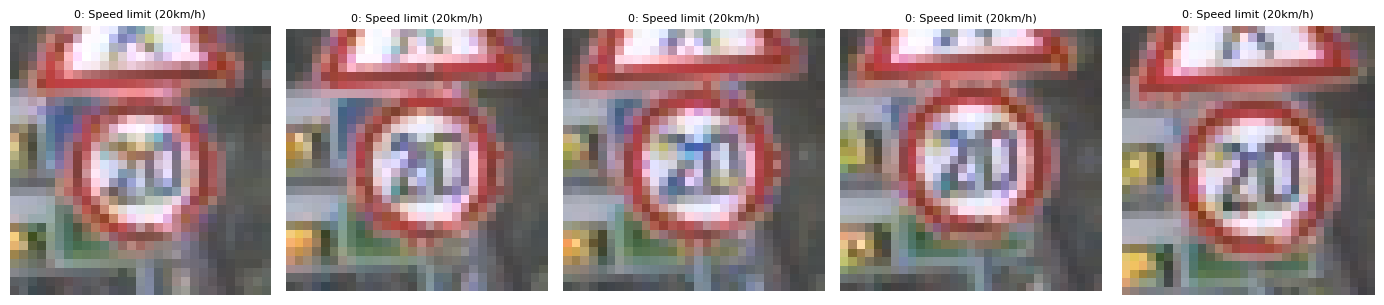

In [6]:
import matplotlib.pyplot as plt
from torchvision import datasets

from src.data import GTSRB_CLASSES

ds = datasets.GTSRB(root=DATA_ROOT, split="train", download=False)

idxs = [0, 1, 2, 3, 4]
fig, axes = plt.subplots(1, len(idxs), figsize=(14, 3))
for ax, i in zip(axes, idxs):
    img, y = ds[i]
    ax.imshow(img)
    ax.set_title(f"{y}: {GTSRB_CLASSES[y]}", fontsize=8)
    ax.axis("off")
plt.tight_layout()
plt.show()


## 5) Train + evaluate

Defaults below are a **quick demo** (small epoch counts). For better accuracy, increase `head_epochs` and `epochs`.


In [7]:
# Quick demo config (edit as needed)
model = "mobilenet_v3_small"  # or "resnet50"
img_size = 96
batch_size = 64
num_workers = 0  # notebook-friendly
head_epochs = 1
epochs = 1

train_cmd = [
    sys.executable,
    "-m",
    "src.train",
    "--data-root",
    str(DATA_ROOT),
    "--output-dir",
    str(OUTPUT_DIR),
    "--model",
    model,
    "--img-size",
    str(img_size),
    "--batch-size",
    str(batch_size),
    "--num-workers",
    str(num_workers),
    "--head-epochs",
    str(head_epochs),
    "--epochs",
    str(epochs),
    "--no-download",
    "--run-gradcam",
]

print("Running:\n ", " ".join(train_cmd))
subprocess.run(train_cmd, check=True)


Running:
  /opt/anaconda3/envs/ece5831-tf/bin/python -m src.train --data-root /Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/data --output-dir /Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/outputs/final_project --model mobilenet_v3_small --img-size 96 --batch-size 64 --num-workers 0 --head-epochs 1 --epochs 1 --no-download --run-gradcam


train:   0%|          | 0/375 [00:00<?, ?it/s]          

[Head] Epoch 1: train_acc=0.2649, val_acc=0.6014


eval:   0%|          | 0/42 [00:00<?, ?it/s]            

[Finetune] Epoch 1: train_acc=0.3590, val_acc=0.7136


Training complete. Artifacts saved to /Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/outputs/final_project


CompletedProcess(args=['/opt/anaconda3/envs/ece5831-tf/bin/python', '-m', 'src.train', '--data-root', '/Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/data', '--output-dir', '/Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/outputs/final_project', '--model', 'mobilenet_v3_small', '--img-size', '96', '--batch-size', '64', '--num-workers', '0', '--head-epochs', '1', '--epochs', '1', '--no-download', '--run-gradcam'], returncode=0)

## 6) Review outputs

Artifacts are written into the output directory:

- `best_model.pt`
- `metrics.json`
- `metrics_summary.png`
- `confusion_matrix.png`
- `reliability.png`
- `gradcam/*.jpg` (when enabled)


best_val_acc: 0.7135885885885885
val: {'accuracy': 0.7135885885885885, 'macro_f1': 0.6527190545275111, 'ece': 0.17145861487265102}
test: {'accuracy': 0.5799683293745052, 'macro_f1': 0.4371609814217827, 'ece': 0.079117382933059}
Displaying: /Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/outputs/final_project/metrics_summary.png


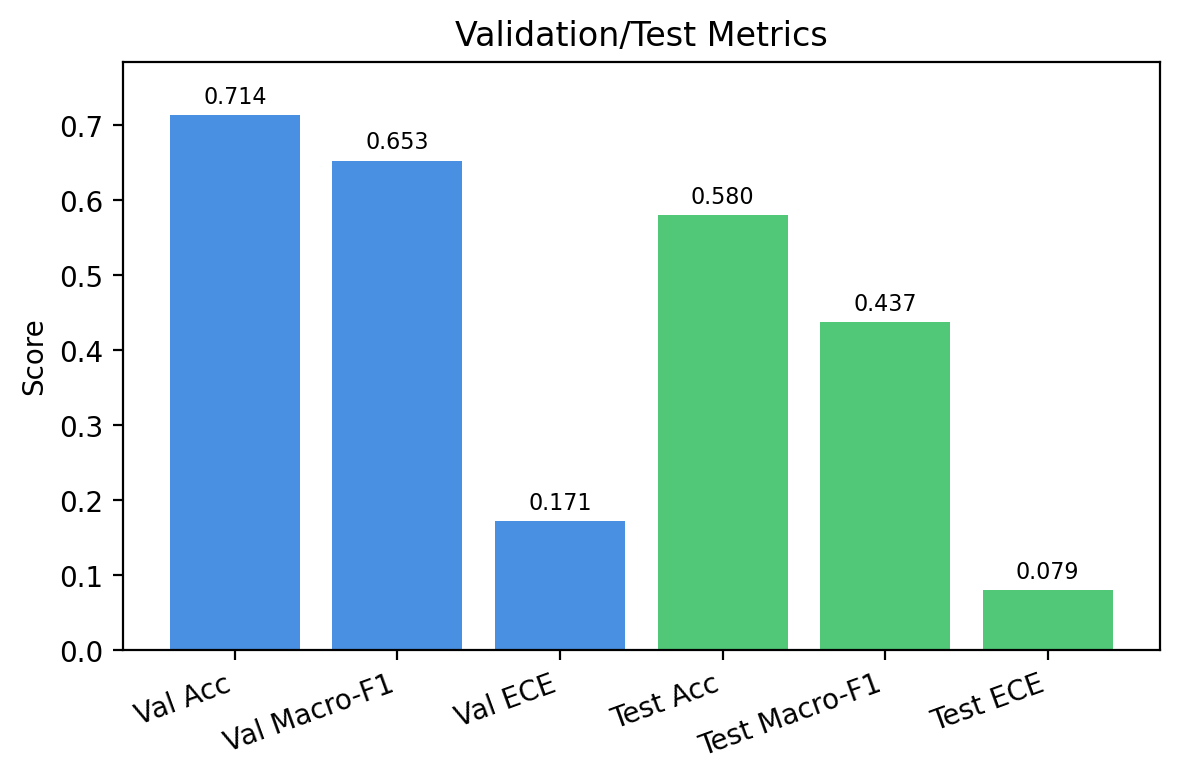

Displaying: /Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/outputs/final_project/confusion_matrix.png


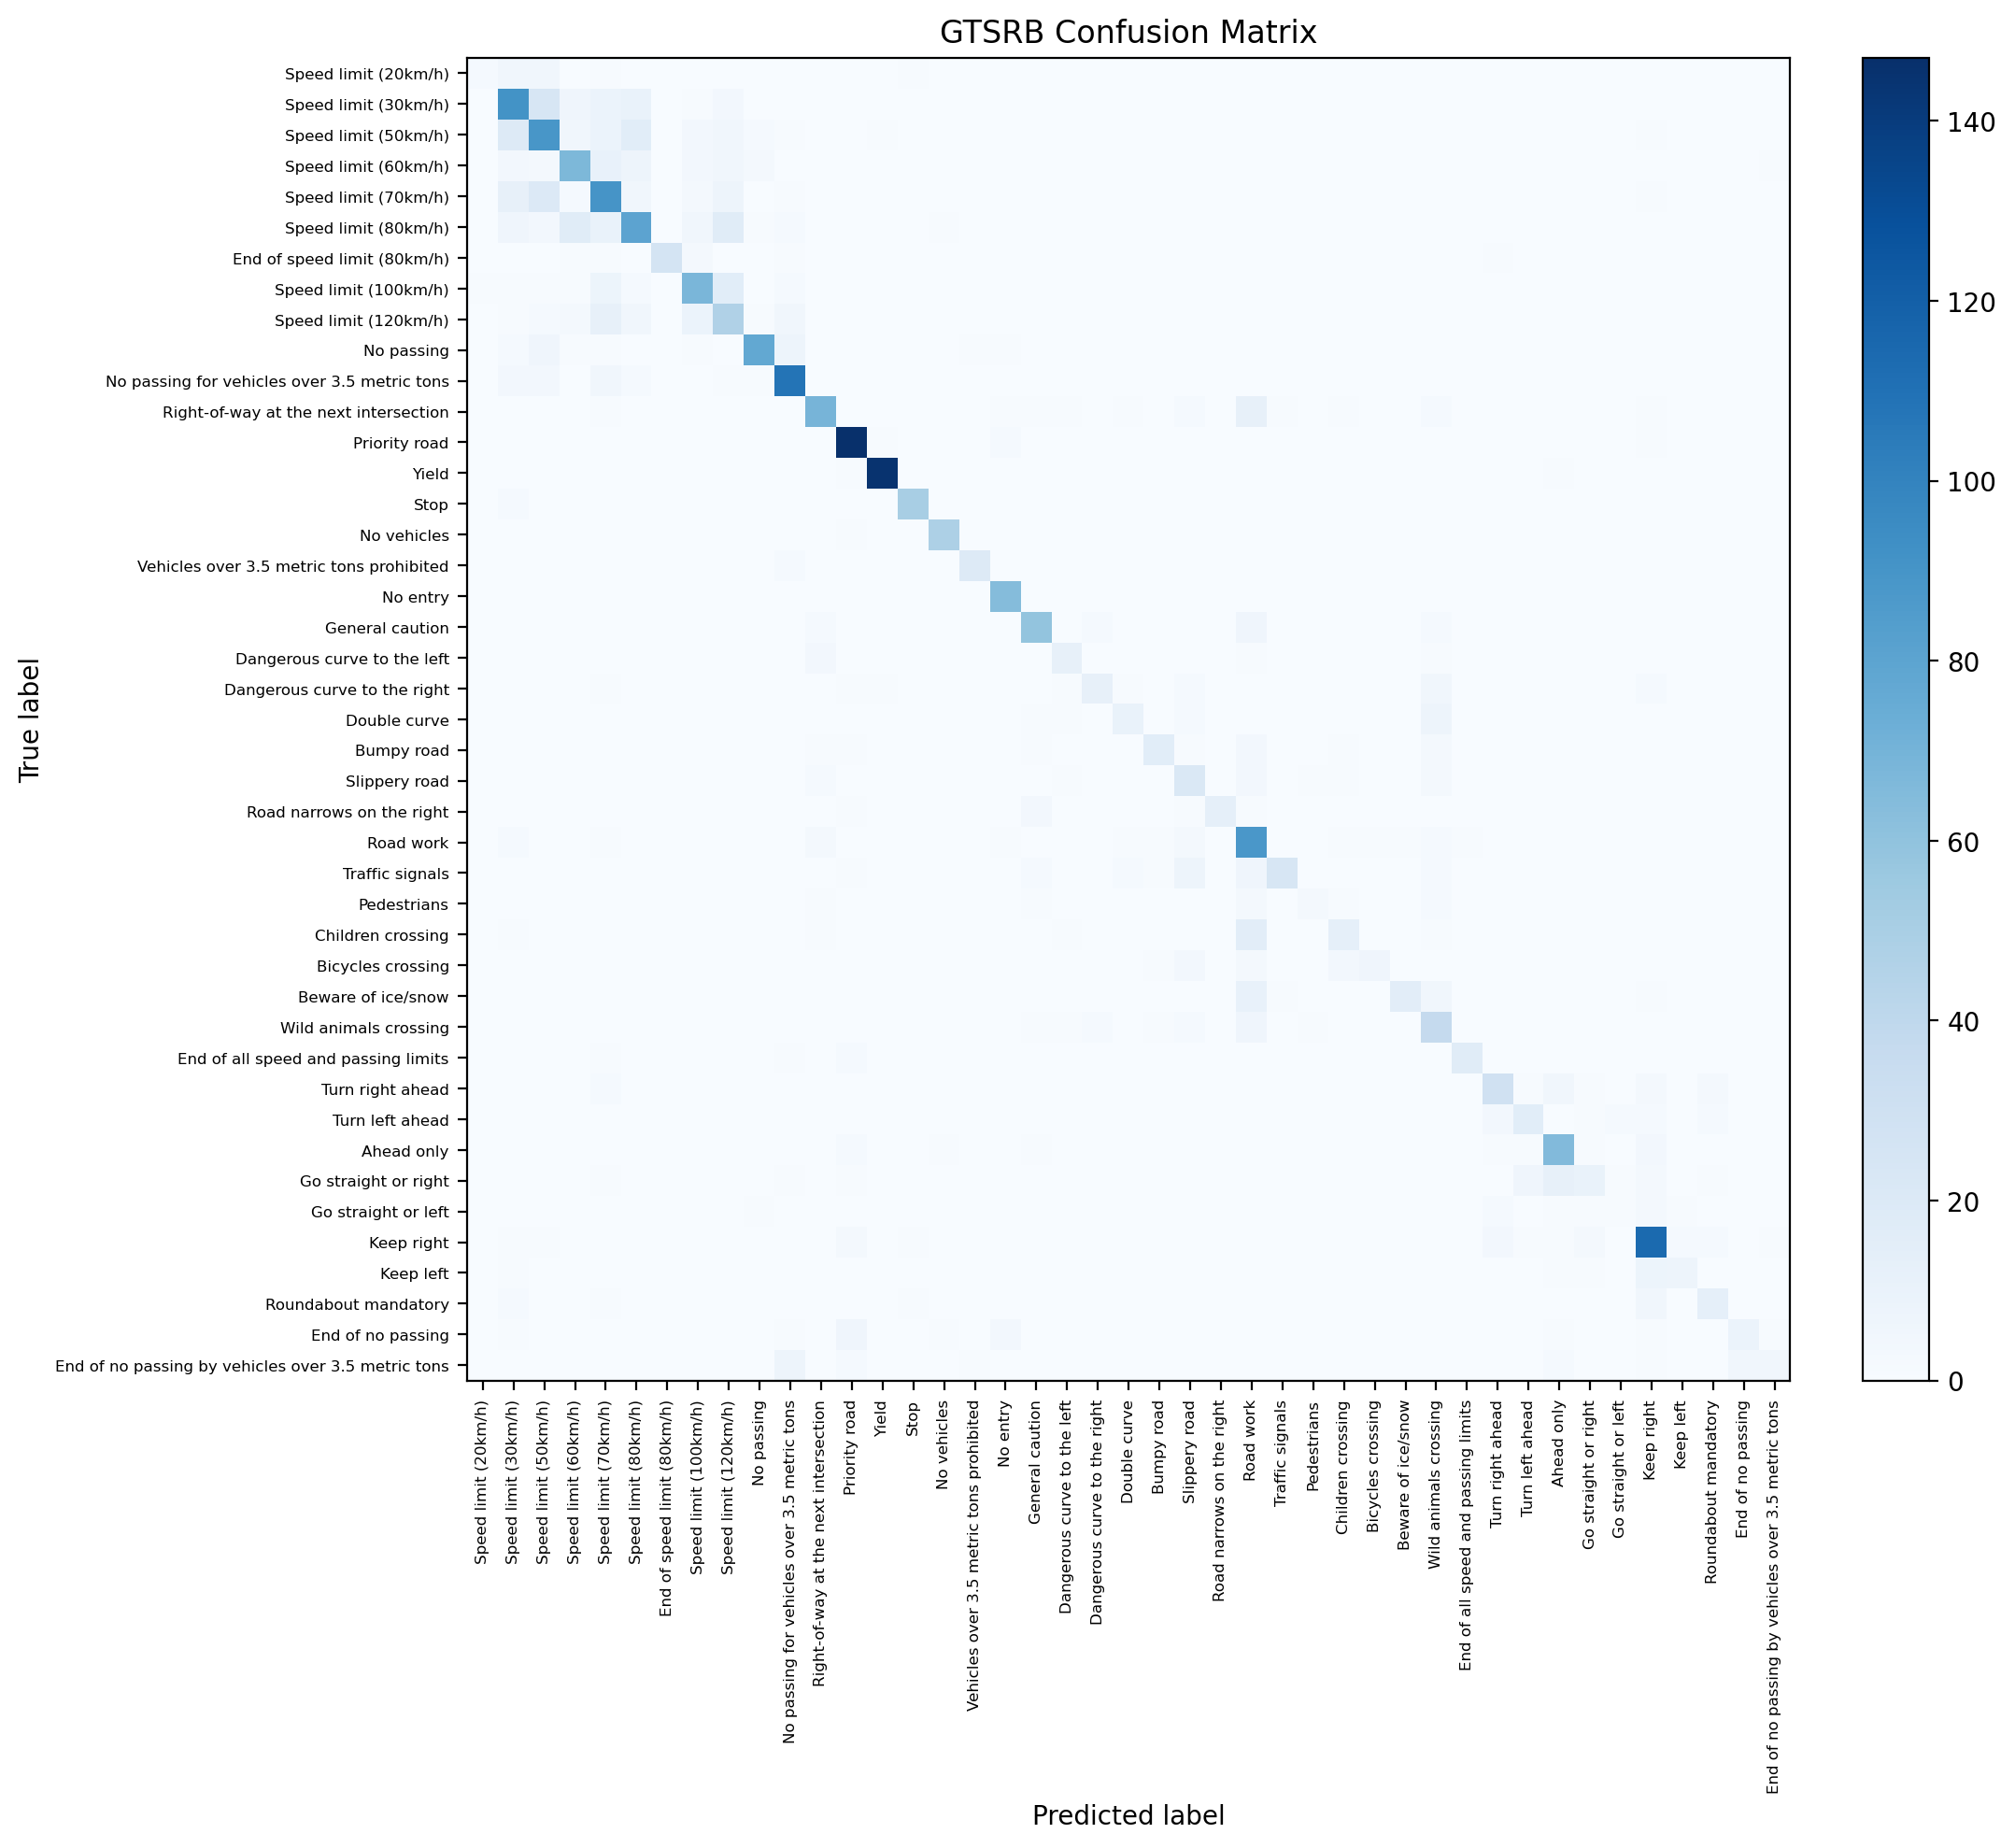

Displaying: /Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/outputs/final_project/reliability.png


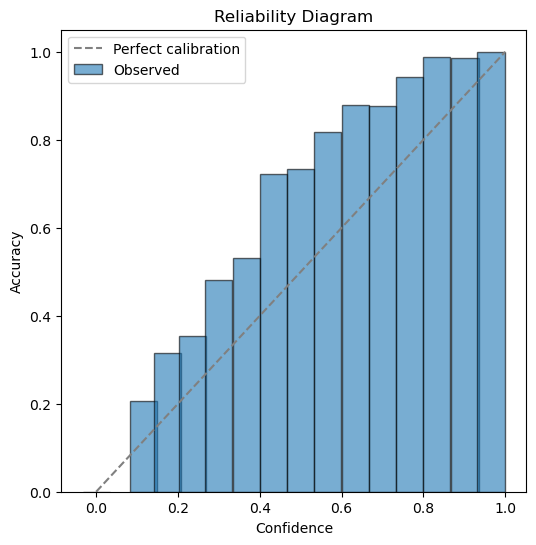

Grad-CAM: gradcam_0_pred-No entry_true-No entry.jpg


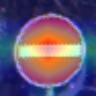

Grad-CAM: gradcam_1_pred-No passing_true-No passing.jpg


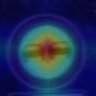

Grad-CAM: gradcam_2_pred-Keep right_true-Keep right.jpg


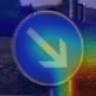

Grad-CAM: gradcam_3_pred-Keep right_true-End of no passing.jpg


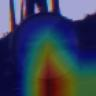

In [8]:
import json
from PIL import Image
from IPython.display import display

metrics_path = OUTPUT_DIR / "metrics.json"
if metrics_path.exists():
    metrics = json.loads(metrics_path.read_text())
    print("best_val_acc:", metrics.get("best_val_acc"))
    print("val:", metrics.get("val"))
    print("test:", metrics.get("test"))
else:
    print("Missing:", metrics_path)

for name in ["metrics_summary.png", "confusion_matrix.png", "reliability.png"]:
    p = OUTPUT_DIR / name
    if p.exists():
        print("Displaying:", p)
        display(Image.open(p))
    else:
        print("Missing:", p)

gradcam_dir = OUTPUT_DIR / "gradcam"
if gradcam_dir.exists():
    samples = sorted(gradcam_dir.glob("*.jpg"))[:4]
    for p in samples:
        print("Grad-CAM:", p.name)
        display(Image.open(p))


## 7) Demo prediction (+ optional Grad-CAM)

This picks a sample image from the downloaded dataset and runs `scripts/predict.py` using the trained checkpoint.


Using sample: true=16 (Vehicles over 3.5 metric tons prohibited)


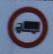

Running:
  /opt/anaconda3/envs/ece5831-tf/bin/python -m scripts.predict --image /Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/outputs/final_project/demo_input.jpg --checkpoint /Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/outputs/final_project/best_model.pt --model mobilenet_v3_small --img-size 96 --gradcam --output /Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/outputs/final_project/demo_gradcam.jpg
Prediction: Vehicles over 3.5 metric tons prohibited (conf=0.622)
Saved Grad-CAM to /Users/anuragc/Documents/ece-5831-002-traffic-sign-transfer/outputs/final_project/demo_gradcam.jpg


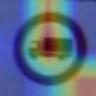

In [9]:
from PIL import Image
from IPython.display import display
from torchvision import datasets

from src.data import GTSRB_CLASSES

test_ds = datasets.GTSRB(root=DATA_ROOT, split="test", download=False)
img, y = test_ds[0]
image_path = OUTPUT_DIR / "demo_input.jpg"
img.save(image_path)
checkpoint_path = OUTPUT_DIR / "best_model.pt"
demo_out = OUTPUT_DIR / "demo_gradcam.jpg"

print(f"Using sample: true={y} ({GTSRB_CLASSES[y]})")
display(Image.open(image_path))

predict_cmd = [
    sys.executable,
    "-m",
    "scripts.predict",
    "--image",
    str(image_path),
    "--checkpoint",
    str(checkpoint_path),
    "--model",
    model,
    "--img-size",
    str(img_size),
    "--gradcam",
    "--output",
    str(demo_out),
]

print("Running:\n ", " ".join(predict_cmd))
subprocess.run(predict_cmd, check=True)

if demo_out.exists():
    display(Image.open(demo_out))
